In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import sympy as sy
import scipy.linalg as la 
import scipy.sparse.linalg as spla
import time 
import matplotlib.pyplot as plt
import cmath
from utils import helper
sy.init_printing()
%matplotlib inline

#### Area of Circle

In [2]:
N = 500 #number of sample points
points = np.random.rand(2,N)

In [3]:
#rescale so that the range falls between [-1,1] x [-1,1]
points = points*2-1

In [4]:
#compute for the euclidean distance
pointsDistances = np.linalg.norm(points, axis=0)
#count how many are less than 1
numInCircle = np.count_nonzero(pointsDistances<1)

#area of circle
circleArea = 4.*(numInCircle/N)
circleArea

In [5]:
#error diff
np.pi - circleArea

### Problem 1. 
Write a function that estimates the volume of the unit sphere. Your function should have a keyword argument `N` that defaults to $10^5$. Your function should draw $N$ points uniformly from $[-1, 1] \times [-1, 1] \times [-1, 1]$ to
make your estimate. The true volume is $\frac{4}{3}\pi \approx 4.189$.

In [6]:
def est_volsphere(N = int(1e5)):
    points = np.random.rand(3,N)
    points = points*2 -1 #rescale it 
    distance = la.norm(points, axis=0)
    counts = np.sum(distance<=1)
    return (2**3)*counts/N

In [7]:
est_vol = est_volsphere()
print("Estimate %f | True Value %f:"%(est_vol, (4*np.pi/3)))
print("Error:", (4*np.pi/3) -est_vol)

Estimate 4.179360 | True Value 4.188790:
Error: 0.00943020478639


### Problem 2.
Write a function that performs 1-dimensional Monte Carlo integration. Given a function $f : \mathbb{R} \mapsto \mathbb{R}$, an interval $[a, b]$, and the number of random points to use, your function should return an approximation of the integral $\int^{b}_{a} f(x) dx$. Let the number of sample points default to $10^5$. Test your function by estimating integrals that you can calculate by hand

In [8]:
def onedim_montecarlo(f, interval, N=int(1e5)):
    length = np.abs(np.diff(interval)) #volume since 1d
    points = np.random.uniform(interval[0], interval[1], size = N)
    mean_image = np.mean(f(points))
    return mean_image*length
    

In [9]:
f = lambda x: x**(2/3)
interval = [1,4]

In [10]:
onedim_montecarlo(f, interval)

array([ 5.44030864])

In [11]:
x = sy.symbols("x")
expr = x**(2/3)
sy.integrate(expr, (x,1,4)).evalf()

### Problem 3. 

Generalize Problem 2 to multiple dimensions. Write a function that accepts a function handle $f$ to integrate, the bounds of the interval to integrate over, and the number of points to use. Let the number of sample points default to $10^5$. Your implementation should be robust enough to integrate any function $f: \mathbb{R}^n \mapsto \mathbb{R}$ over any interval in $\mathbb{R}^n$.

In [12]:
def gen_montecarlo(f, interval, N=int(1e5)):
    #interval should be of shape (n,2) where n is the dimension of domain of f
    
    points = np.random.rand(len(interval), N)
    points = points*np.diff(interval, axis=1) + np.min(interval, axis=1, keepdims=True) #rescale
    range_ = np.apply_along_axis(f, 0, points)
    mean_ = np.mean(range_)
    return mean_*np.product(np.abs(np.diff(interval, axis=1)))

### Problem 4. 
The joint normal distribution of N independent random variables with mean 0 and variance 1 is
$$f(x) = \frac{1}{\sqrt{2\pi}^N}e^{-\frac{x^Tx}{2}}$$

The integral of $f(x)$ over a box is the probability that a draw from the distribution will be in the box. This is an important distribution in statistics. However, $f(x)$ does not have a symbolic antiderivative.

1. Let $\Omega = [-1.5,0.75]\times[0,1]\times[0,0.5]\times[0,1] \subset \mathbb{R}^4$. Use the function you wrote in Problem 1 to integrate $f(x)$ on $\Omega$. Use 50000 sample points.

2. SciPy has a built in function specifically for integrating the joint normal distribution. The integral of $f(x)$ on $B = [-1,1]\times[-1,1]\times[-1,1] \subset \mathbb{R}^3$ can be computed in SciPy with the following code.

￼
        >>> from scipy import stats
        # Define the bounds of the box to integrate over
        >>> mins = np.array([-1, -1, -1])
        >>> maxs = np.array([1, 1, 1])
        # Each variable has mean 0
        >>> means = np.zeros(3)
        # The covariance matrix of N independent random variables
        #    is the NxN identity matrix.
        >>> covs = np.eye(3)
        # Compute the integral
        >>> value, inform = stats.mvn.mvnun(mins, maxs, means, covs)

    
Then `value` is the integral of $f(x)$ on $B$.
Use SciPy to integrate $f(x)$ on $\Omega$.

3. Return your Monte Carlo estimate, SciPy’s answer, and (assuming SciPy is correct) the relative error of your Monte Carlo estimate.

In [13]:
f = lambda x: np.exp(-np.dot(x,x)/2)/(np.sqrt(2*np.pi)**len(x))

In [14]:
omega = np.array([[-1.5, 0.75],
                  [0,1],
                  [0,0.5],
                  [0,1]])

In [15]:
value_est = gen_montecarlo(f, omega, N=50000)
value_est

In [16]:
#using scipy 
mins = np.array([-1.5, 0, 0, 0])
maxs = np.array([0.75, 1, 0.5, 1])

means = np.zeros(4)
covs = np.eye(4)
value, inform = stats.mvn.mvnun(mins, maxs, means, covs)
value

In [17]:
value_est - value

### Problem 5. 
In this problem we will visualize how the error in Monte Carlo integration depends on the number of sample points.

Run Problem 1 with N equal to 50, 100 and 500, as well as 1000, 2000, 3000, ..., 50000; having some additional small values of N will help make the visualization better.

For each value of N:

    1. Estimate the volume of the unit sphere using Problem 1, and use the true volume to calculate the relative error of the estimate.
    2. Repeat this multiple times to get an average estimate of the relative error. Your function should accept a keyword argument numEstimates that defaults to 50.
    3. Calculate and store the mean of the errors.
    Plot the mean relative error as a function of N. For comparison, plot the function 1/pN on the same graph. Your plot should resemble Figure 12.2)

In [18]:
Ns = np.append(np.array([50, 100, 500]), np.arange(1,51)*1000)
numEstimates = 50

In [19]:
def relative_error_volsphere(Ns, numEstimates):
    true_vol = (4*np.pi/3)
    errors_N = []
    for N in Ns:
        errors = []
        for i in range(numEstimates):
            vol = est_volsphere(N=N)
            errors.append(np.abs(vol-true_vol)/true_vol)
        errors_N.append(np.mean(errors))
        
    plt.figure(figsize=(10, 8))
    plt.plot(Ns, errors_N)
    plt.plot(Ns, 1/np.sqrt(Ns), 'r--')

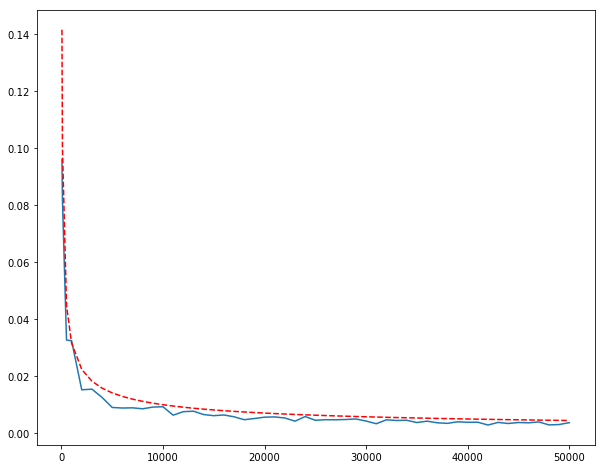

In [20]:
relative_error_volsphere(Ns, numEstimates)